# IMPORT LIBS

In [3]:
import sys
sys.path.insert(1, "/home/lucas/AffectiveComputing")

from keras.layers import Embedding, Dropout, Dense, Conv1D, GlobalMaxPooling1D
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from libs.sqlite_manager import Sqlite as slq3
from sklearn.preprocessing import LabelEncoder
from libs.pre_processing import PreProcessing 
from keras.optimizers import Adam, AdamW
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
from keras.models import Sequential
import matplotlib.pyplot as plt
from random import choice
import tensorflow as tf
from os import environ
import seaborn as sns
import pandas as pd
import numpy as np
from random import choice

model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

path = '/home/lucas/AffectiveComputing/data_source/ceweb/test.csv'

pp = PreProcessing()
filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LOAD DATA

In [2]:
emotion_name = {0: 'admiração', 1: 'diversão', 2: 'raiva', 3: 'aborrecimento',
                4: 'provação', 5: 'confusão', 6: 'curiosidade', 7: 'desejo',
                8: 'decepção', 9: 'desaprovação', 10: 'nojo', 11: 'vergonha', 
                12: 'entusiasmo', 13: 'medo', 14: 'gratidão', 15: 'luto', 
                16: 'alegria', 17: 'amor', 18: 'nervosismo', 19: 'otimismo',
                20: 'orgulho', 21: 'alívio', 22: 'remorso', 23: 'tristeza',  
                24: 'surpresa', 25: 'saudade', 26: 'inveja', 27: 'compaixão'}

In [3]:
def _preprocessing_train(dataframe, column):
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.set_category(dataframe, 'categoria')
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.shuffled_dataframe(dataframe)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [12]:
data = pd.read_csv(path, delimiter='\t')
data = _preprocessing_train(data, "tweet")
texts = data.tweet
labels = np.array(data.categoria.tolist())

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the texts
def tokenize_text(text):
    inputs = tokenizer(text, max_length=64, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'].numpy().flatten()

# Convert texts to input_ids
inputs_train = np.array([tokenize_text(text) for text in texts_train])
inputs_val = np.array([tokenize_text(text) for text in texts_val])

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_val_encoded = label_encoder.transform(labels_val)

# CONVOLUTIONAL BERT

In [14]:
## find best accuracy
np.random.seed(42)
tf.random.set_seed(42)

# Define the model-building function
def build_model(embedding_dim, filters, kernel_size, dense_units, learning_rate, dropout_rate):
    model = Sequential([
        Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=embedding_dim, input_length=64),
        Conv1D(filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate, seed=42),
        Dense(28, activation='softmax')]
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define hyperparameter search space
hyperparameter_search_space = {
    'embedding_dim': [100, 150, 200, 250, 500],
    'filters': [64, 128, 256, 512],
    'kernel_size': [3, 5, 7],
    'dense_units': [32, 64, 128],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.1, 0.2, 0.5]
}

best_accuracy = 0
best_hyperparameters = None

# Perform random search
num_random_searches = 15  # You can adjust this based on the number of random configurations to try
all_hyperparameters = []
best_model = None
for i in range(num_random_searches):
    print(f"TESTE {i}\n\n")
    # Randomly sample hyperparameters
    random_hyperparameters = {
        'embedding_dim': choice(hyperparameter_search_space['embedding_dim']),
        'filters': choice(hyperparameter_search_space['filters']),
        'kernel_size': choice(hyperparameter_search_space['kernel_size']),
        'dense_units': choice(hyperparameter_search_space['dense_units']),
        'learning_rate': choice(hyperparameter_search_space['learning_rate']),
        'dropout_rate': choice(hyperparameter_search_space['dropout_rate'])
    }

    # Build and train the model
    model = build_model(**random_hyperparameters)
    model.fit(inputs_train, labels_train_encoded, epochs=5, verbose=1)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(inputs_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    accuracy = accuracy_score(labels_val_encoded, y_val_pred_classes)

    # Print current hyperparameters and accuracy
    print(f'Accuracy on validation set: {accuracy}')
    random_hyperparameters['accuracy'] = accuracy
    all_hyperparameters.append(random_hyperparameters)
    print(f'\nHyperparameters: {random_hyperparameters}')
    print()
    # Update best hyperparameters if the current configuration performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = random_hyperparameters
        best_model = model

# Print the best hyperparameters
print(f'Best hyperparameters: {best_hyperparameters}')


TESTE 0


Epoch 1/5
313/313 [==============================] - 20s 62ms/step - loss: 2.7204 - accuracy: 0.2654
Epoch 2/5
313/313 [==============================] - 20s 63ms/step - loss: 1.2955 - accuracy: 0.6923
Epoch 3/5
313/313 [==============================] - 20s 63ms/step - loss: 0.7225 - accuracy: 0.8255
Epoch 4/5
313/313 [==============================] - 20s 63ms/step - loss: 0.4524 - accuracy: 0.8921
Epoch 5/5
79/79 [==============================] - 0s 1ms/step
Accuracy on validation set: 0.774890043982407

Hyperparameters: {'embedding_dim': 150, 'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'accuracy': 0.774890043982407}

TESTE 1


Epoch 1/5
313/313 [==============================] - 28s 87ms/step - loss: 2.5708 - accuracy: 0.2958
Epoch 2/5
313/313 [==============================] - 27s 87ms/step - loss: 2.3650 - accuracy: 0.3365
Epoch 3/5
313/313 [==============================] - 27s 87ms/step - loss: 2.3052 - accuracy: 

In [20]:
all_hyperparameters = pd.DataFrame(all_hyperparameters).sort_values(by='accuracy', ascending=False)
all_hyperparameters

,embedding_dim,filters,kernel_size,dense_units,learning_rate,dropout_rate,accuracy
0,150,64,5,128,0.0010,0.5,0.774890
5,150,128,5,32,0.0010,0.5,0.767293
6,200,512,5,64,0.0010,0.2,0.766094
2,250,256,7,128,0.0010,0.2,0.763295
3,250,256,5,128,0.0010,0.2,0.762095
4,100,512,7,32,0.0010,0.1,0.755298
11,150,512,3,128,0.0001,0.2,0.673331
7,250,64,3,32,0.0100,0.1,0.670532
10,150,256,5,64,0.0100,0.1,0.659736
9,250,512,3,64,0.0001,0.5,0.651339


In [38]:
## find best accuracy
np.random.seed(42)
tf.random.set_seed(42)
hyperparameters = {'embedding_dim': 150, 'filters': 64, 'kernel_size': 5, 
                   'dense_units': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5}

# Define the model-building function
def build_model(embedding_dim, filters, kernel_size, dense_units, learning_rate, dropout_rate):
    model = Sequential([
            Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=embedding_dim, input_length=64),
            Conv1D(filters, kernel_size, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate,  seed=42),
            Dense(28, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_model(**hyperparameters)
model.fit(inputs_train, labels_train_encoded, epochs=5, verbose=1)

# Evaluate the model on the validation set
y_val_pred = model.predict(inputs_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
accuracy = accuracy_score(labels_val_encoded, y_val_pred_classes)

# Print current hyperparameters and accuracy
print(f'Accuracy on validation set: {accuracy}')

Epoch 1/5
313/313 [==============================] - 19s 61ms/step - loss: 2.6629 - accuracy: 0.2766
Epoch 2/5
313/313 [==============================] - 19s 61ms/step - loss: 1.2952 - accuracy: 0.6884
Epoch 3/5
313/313 [==============================] - 19s 61ms/step - loss: 0.7493 - accuracy: 0.8215
Epoch 4/5
313/313 [==============================] - 19s 62ms/step - loss: 0.4604 - accuracy: 0.8889
Epoch 5/5
79/79 [==============================] - 0s 1ms/step
Accuracy on validation set: 0.7672930827668932


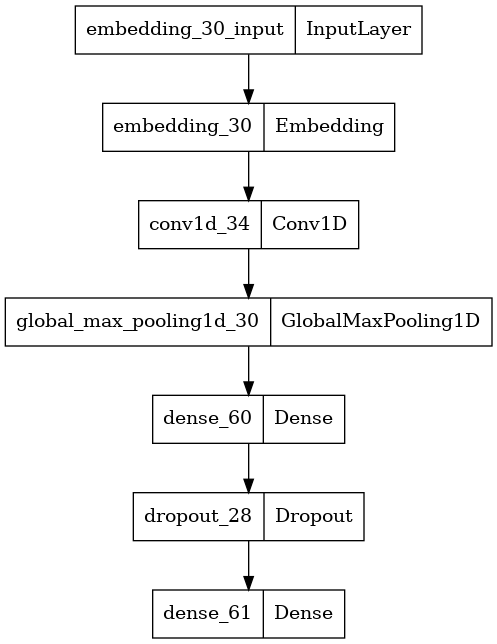

In [40]:
tf.keras.utils.plot_model(
    model)

In [43]:
# Use classification report for more detailed metrics
y_val_pred = model.predict(inputs_val)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)

labels_val_names = [emotion_name[label] for label in labels_val_encoded]
pred_labels_names = [emotion_name[label] for label in y_val_pred_classes]
print('\nClassification Report:')
print(classification_report(labels_val_names, pred_labels_names))

79/79 [==============================] - 0s 1ms/step

Classification Report:
               precision    recall  f1-score   support

aborrecimento       0.91      0.88      0.89        57
    admiração       0.85      0.74      0.79       129
      alegria       0.64      0.70      0.67       111
       alívio       0.81      0.88      0.85        59
         amor       0.80      0.67      0.73        79
    compaixão       0.78      0.63      0.70        49
     confusão       0.92      0.89      0.90       279
  curiosidade       0.85      0.85      0.85        61
     decepção       0.80      0.83      0.81        42
 desaprovação       0.77      0.75      0.76        32
       desejo       0.65      0.75      0.70       200
     diversão       0.73      0.77      0.75       203
   entusiasmo       0.88      0.82      0.85       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.92      0.79      0.85        70
         luto       0.71      0.57      0.

In [44]:
report_e = classification_report(labels_val_names, pred_labels_names, output_dict=True)
df_report_e = pd.DataFrame(report_e).transpose()
df_report_e

,precision,recall,f1-score,support
aborrecimento,0.909091,0.877193,0.892857,57.000000
admiração,0.849558,0.744186,0.793388,129.000000
alegria,0.644628,0.702703,0.672414,111.000000
alívio,0.812500,0.881356,0.845528,59.000000
amor,0.803030,0.670886,0.731034,79.000000
compaixão,0.775000,0.632653,0.696629,49.000000
confusão,0.918519,0.888889,0.903461,279.000000
curiosidade,0.852459,0.852459,0.852459,61.000000
decepção,0.795455,0.833333,0.813953,42.000000
desaprovação,0.774194,0.750000,0.761905,32.000000


In [45]:
df_report_emb_emotions = df_report_e.drop(['accuracy', 'macro avg', 'weighted avg'])

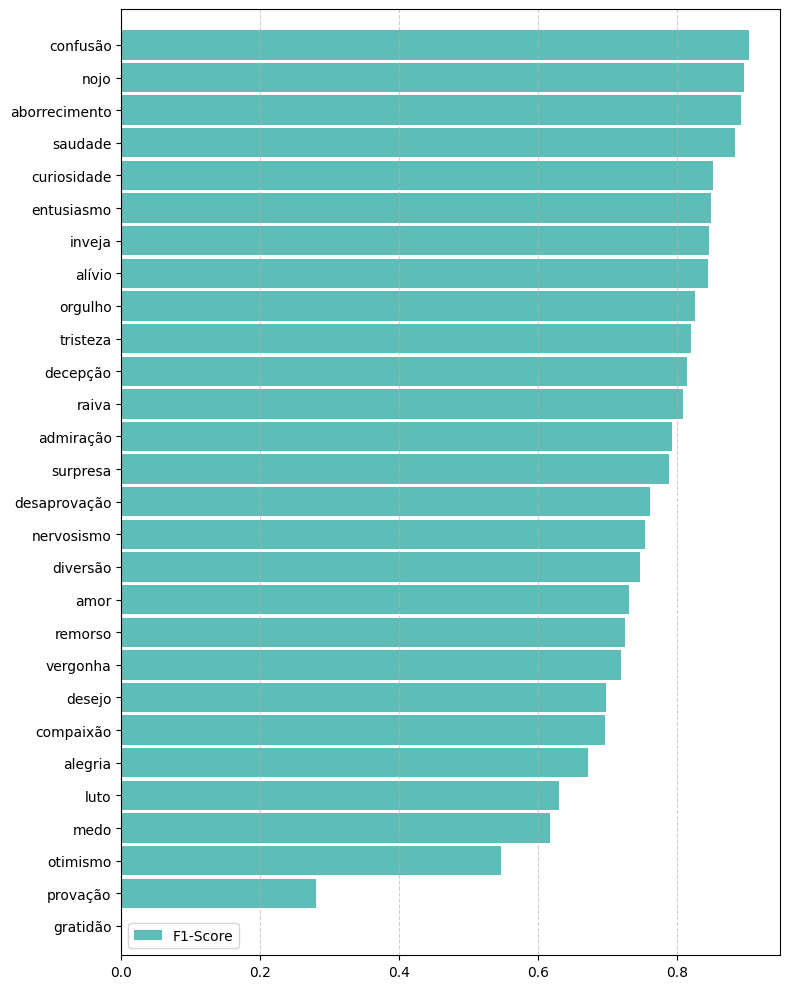

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

metric_to_compare = 'f1-score'


df_report_emb_emotions = df_report_emb_emotions.sort_values(by=metric_to_compare, ascending=True)


colors = sns.color_palette("husl", 2)

fig, ax = plt.subplots(figsize=(8, 10))

bar_height = 0.9
bar_positions_tf = np.arange(len(df_report_emb_emotions))
bar_positions_cv = bar_positions_tf + bar_height

ax.barh(bar_positions_cv, df_report_emb_emotions[metric_to_compare], height=bar_height, label='F1-Score', color=colors[1], alpha=0.8)

ax.set_yticks(bar_positions_tf + bar_height)
ax.set_yticklabels(df_report_emb_emotions.index)

ax.legend(loc='best')

ax.grid(axis='x', linestyle='--', alpha=0.6)

ax.set_ylim(0, len(df_report_emb_emotions)+1)
plt.tight_layout()
plt.show()



# MORE DROPOUT

In [47]:
## find best accuracy
np.random.seed(42)
tf.random.set_seed(42)
hyperparameters = {'embedding_dim': 150, 'filters': 64, 'kernel_size': 5, 
                   'dense_units': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5}

# Define the model-building function
def build_model(embedding_dim, filters, kernel_size, dense_units, learning_rate, dropout_rate):
    model = Sequential([
            Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=embedding_dim, input_length=64),
            Conv1D(filters, kernel_size, activation='relu'),
            Dropout(dropout_rate,  seed=42),
            GlobalMaxPooling1D(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate,  seed=42),
            Dense(28, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_model(**hyperparameters)
model.fit(inputs_train, labels_train_encoded, epochs=4, verbose=1)

# Evaluate the model on the validation set
y_val_pred = model.predict(inputs_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
accuracy = accuracy_score(labels_val_encoded, y_val_pred_classes)

# Print current hyperparameters and accuracy
print(f'Accuracy on validation set: {accuracy}')

Epoch 1/4
313/313 [==============================] - 20s 61ms/step - loss: 2.8247 - accuracy: 0.2284
Epoch 2/4
313/313 [==============================] - 19s 61ms/step - loss: 1.5437 - accuracy: 0.6205
Epoch 3/4
313/313 [==============================] - 19s 61ms/step - loss: 0.9299 - accuracy: 0.7706
Epoch 4/4
79/79 [==============================] - 0s 1ms/step
Accuracy on validation set: 0.7644942023190724


In [48]:
# Use classification report for more detailed metrics
y_val_pred = model.predict(inputs_val)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)

labels_val_names = [emotion_name[label] for label in labels_val_encoded]
pred_labels_names = [emotion_name[label] for label in y_val_pred_classes]
print('\nClassification Report:')
print(classification_report(labels_val_names, pred_labels_names))

 1/79 [..............................] - ETA: 0s

79/79 [==============================] - 0s 1ms/step

Classification Report:
               precision    recall  f1-score   support

aborrecimento       0.84      0.75      0.80        57
    admiração       0.86      0.82      0.84       129
      alegria       0.50      0.64      0.56       111
       alívio       0.87      0.90      0.88        59
         amor       0.78      0.67      0.72        79
    compaixão       0.76      0.59      0.67        49
     confusão       0.92      0.90      0.91       279
  curiosidade       0.88      0.82      0.85        61
     decepção       0.76      0.88      0.81        42
 desaprovação       0.85      0.69      0.76        32
       desejo       0.76      0.69      0.72       200
     diversão       0.74      0.78      0.76       203
   entusiasmo       0.91      0.83      0.87       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.95      0.81      0.88        70
         luto       0.58      0.68      0.

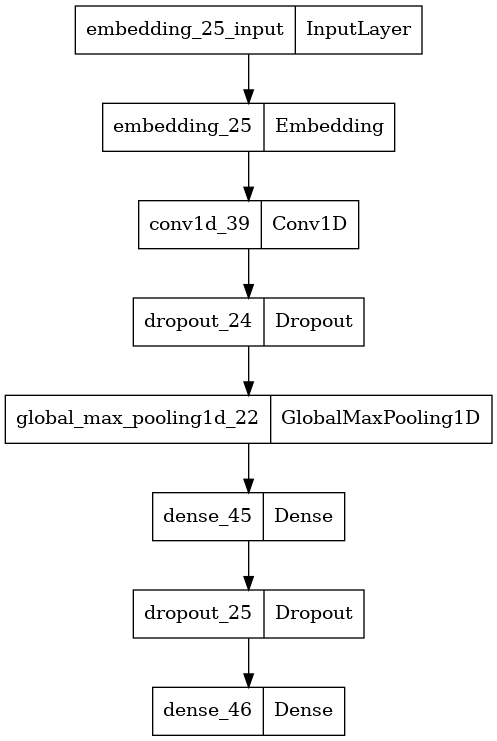

In [49]:
tf.keras.utils.plot_model(
    model)

In [50]:
report_d = classification_report(labels_val_names, pred_labels_names, output_dict=True)
report_d = pd.DataFrame(report_d).transpose()
report_d

,precision,recall,f1-score,support
aborrecimento,0.843137,0.754386,0.796296,57.000000
admiração,0.861789,0.821705,0.841270,129.000000
alegria,0.503546,0.639640,0.563492,111.000000
alívio,0.868852,0.898305,0.883333,59.000000
amor,0.779412,0.670886,0.721088,79.000000
compaixão,0.763158,0.591837,0.666667,49.000000
confusão,0.916058,0.899642,0.907776,279.000000
curiosidade,0.877193,0.819672,0.847458,61.000000
decepção,0.755102,0.880952,0.813187,42.000000
desaprovação,0.846154,0.687500,0.758621,32.000000


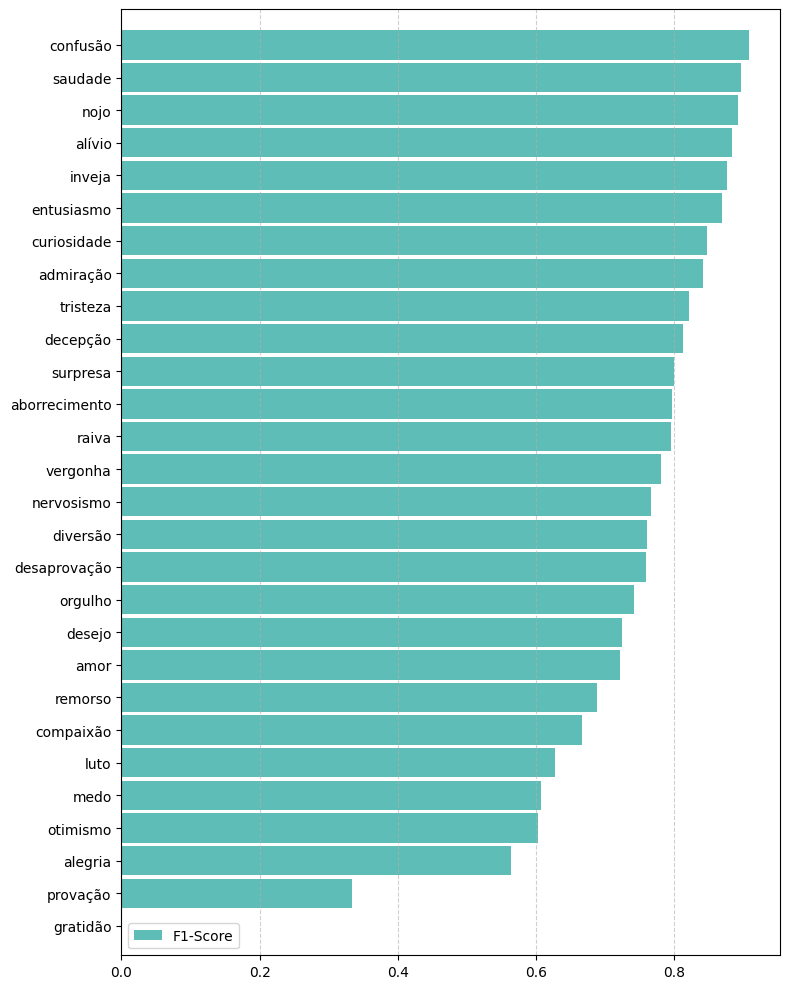

In [51]:
df_report_dropout = report_d.drop(['accuracy', 'macro avg', 'weighted avg'])
metric_to_compare = 'f1-score'


df_report_dropout = df_report_dropout.sort_values(by=metric_to_compare, ascending=True)


colors = sns.color_palette("husl", 2)

fig, ax = plt.subplots(figsize=(8, 10))

bar_height = 0.9
bar_positions_tf = np.arange(len(df_report_dropout))
bar_positions_cv = bar_positions_tf + bar_height

ax.barh(bar_positions_cv, df_report_dropout[metric_to_compare], height=bar_height, label='F1-Score', color=colors[1], alpha=0.8)

ax.set_yticks(bar_positions_tf + bar_height)
ax.set_yticklabels(df_report_dropout.index)

ax.legend(loc='best')

ax.grid(axis='x', linestyle='--', alpha=0.6)

ax.set_ylim(0, len(df_report_dropout)+1)
plt.tight_layout()
plt.show()



# DCNN BIGGER

In [158]:
path = "/home/lucas/AffectiveComputing/songs_database.db"
slq3_instance = slq3(database=path)
inputs = slq3_instance.get_by_select(query='SELECT * FROM inputs;')
emotion_name = slq3_instance.get_by_select(query="SELECT name_emotion FROM emotion")
emotion_name = emotion_name.to_dict()["name_emotion"]
inputs = pp.shuffled_dataframe(inputs)

In [159]:
texts = inputs.text_name
labels = np.array(inputs.emotion_id.tolist())
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the texts
def tokenize_text(text):
    inputs = tokenizer(text, max_length=512, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'].numpy().flatten()

# Convert texts to input_ids
inputs_train = np.array([tokenize_text(text) for text in texts_train])
inputs_val = np.array([tokenize_text(text) for text in texts_val])

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_val_encoded = label_encoder.transform(labels_val)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

def build_model(embedding_dim, filters, kernel_size, dense_units, learning_rate, dropout_rate):
    model = Sequential([
        Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=embedding_dim, input_length=64),
        Conv1D(filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate, seed=42),
        Dense(28, activation='softmax')]
    )

    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

hyperparameter_search_space = {
    'embedding_dim': [100, 150, 200, 250, 500],
    'filters': [64, 128, 256, 512],
    'kernel_size': [3, 5, 7],
    'dense_units': [32, 64, 128],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.1, 0.2, 0.5]
}

best_accuracy = 0
best_hyperparameters = None

num_random_searches = 7  
all_hyperparameters = []
best_model = None
for i in range(num_random_searches):
    print(f"TESTE {i}\n\n")
    random_hyperparameters = {
        'embedding_dim': choice(hyperparameter_search_space['embedding_dim']),
        'filters': choice(hyperparameter_search_space['filters']),
        'kernel_size': choice(hyperparameter_search_space['kernel_size']),
        'dense_units': choice(hyperparameter_search_space['dense_units']),
        'learning_rate': choice(hyperparameter_search_space['learning_rate']),
        'dropout_rate': choice(hyperparameter_search_space['dropout_rate'])
    }

    model = build_model(**random_hyperparameters)
    model.fit(inputs_train, labels_train_encoded, epochs=5, verbose=1)

    y_val_pred = model.predict(inputs_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    accuracy = accuracy_score(labels_val_encoded, y_val_pred_classes)

    print(f'Accuracy on validation set: {accuracy}')
    random_hyperparameters['accuracy'] = accuracy
    all_hyperparameters.append(random_hyperparameters)
    print(f'\nHyperparameters: {random_hyperparameters}')
    print()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = random_hyperparameters
        best_model = model

print(f'Best hyperparameters: {best_hyperparameters}')

TESTE 0


Epoch 1/5


2024-01-09 17:31:54.107634: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59590000 exceeds 10% of free system memory.
2024-01-09 17:31:54.119157: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59590000 exceeds 10% of free system memory.
2024-01-09 17:31:54.132060: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59590000 exceeds 10% of free system memory.
2024-01-09 17:31:54.315900: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59590000 exceeds 10% of free system memory.
2024-01-09 17:31:54.323697: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59590000 exceeds 10% of free system memory.


742/742 [==============================] - 184s 247ms/step - loss: 1.5408 - accuracy: 0.6058
Epoch 2/5
742/742 [==============================] - 182s 245ms/step - loss: 0.5047 - accuracy: 0.8687
Epoch 3/5
742/742 [==============================] - 182s 245ms/step - loss: 0.2288 - accuracy: 0.9407
Epoch 4/5
742/742 [==============================] - 182s 246ms/step - loss: 0.1176 - accuracy: 0.9700
Epoch 5/5
186/186 [==============================] - 1s 2ms/step
Accuracy on validation set: 0.8245998315080034

Hyperparameters: {'embedding_dim': 500, 'filters': 64, 'kernel_size': 5, 'dense_units': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'accuracy': 0.8245998315080034}

TESTE 1


Epoch 1/5
742/742 [==============================] - 35s 46ms/step - loss: 2.3367 - accuracy: 0.3434
Epoch 2/5
742/742 [==============================] - 34s 46ms/step - loss: 1.9239 - accuracy: 0.4800
Epoch 3/5
742/742 [==============================] - 32s 43ms/step - loss: 1.8100 - accuracy: 0.5195
Ep

In [161]:
np.random.seed(42)
tf.random.set_seed(42)
hyperparameters = {'embedding_dim': 150, 'filters': 512, 'kernel_size': 3, 
                   'dense_units': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5}

def build_model(embedding_dim, filters, kernel_size, dense_units, learning_rate, dropout_rate):
    model = Sequential([
            Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=embedding_dim, input_length=512),
            Conv1D(filters, kernel_size, activation='relu'),
            Dropout(dropout_rate,  seed=42),
            GlobalMaxPooling1D(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate,  seed=42),
            Dense(28, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_model(**hyperparameters)
model.fit(inputs_train, labels_train_encoded, epochs=4, verbose=1)

y_val_pred = model.predict(inputs_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
accuracy = accuracy_score(labels_val_encoded, y_val_pred_classes)

print(f'Accuracy on validation set: {accuracy}')

Epoch 1/4
742/742 [==============================] - 135s 182ms/step - loss: 1.8202 - accuracy: 0.5229
Epoch 2/4
742/742 [==============================] - 135s 182ms/step - loss: 0.7487 - accuracy: 0.8093
Epoch 3/4
742/742 [==============================] - 136s 183ms/step - loss: 0.5219 - accuracy: 0.8597
Epoch 4/4
186/186 [==============================] - 4s 19ms/step
Accuracy on validation set: 0.8175231676495367


In [162]:
y_val_pred = model.predict(inputs_val)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)

labels_val_names = [emotion_name[label] for label in labels_val_encoded]
pred_labels_names = [emotion_name[label] for label in y_val_pred_classes]
print('\nClassification Report:')
print(classification_report(labels_val_names, pred_labels_names))

186/186 [==============================] - 4s 19ms/step

Classification Report:
               precision    recall  f1-score   support

aborrecimento       0.90      0.95      0.92       204
    admiração       0.82      0.87      0.84       298
      alegria       0.71      0.67      0.69       212
       alívio       0.81      0.85      0.83       210
         amor       0.85      0.74      0.79       190
    compaixão       0.87      0.86      0.87       219
     confusão       0.95      0.84      0.89       323
  curiosidade       0.90      0.88      0.89       193
     decepção       0.94      0.96      0.95       200
 desaprovação       0.93      0.87      0.90       191
       desejo       0.81      0.64      0.72       207
     diversão       0.78      0.73      0.75       208
   entusiasmo       0.74      0.77      0.76       194
     gratidão       0.85      0.95      0.90       201
       inveja       0.87      0.90      0.88       226
         luto       0.64      0.81     

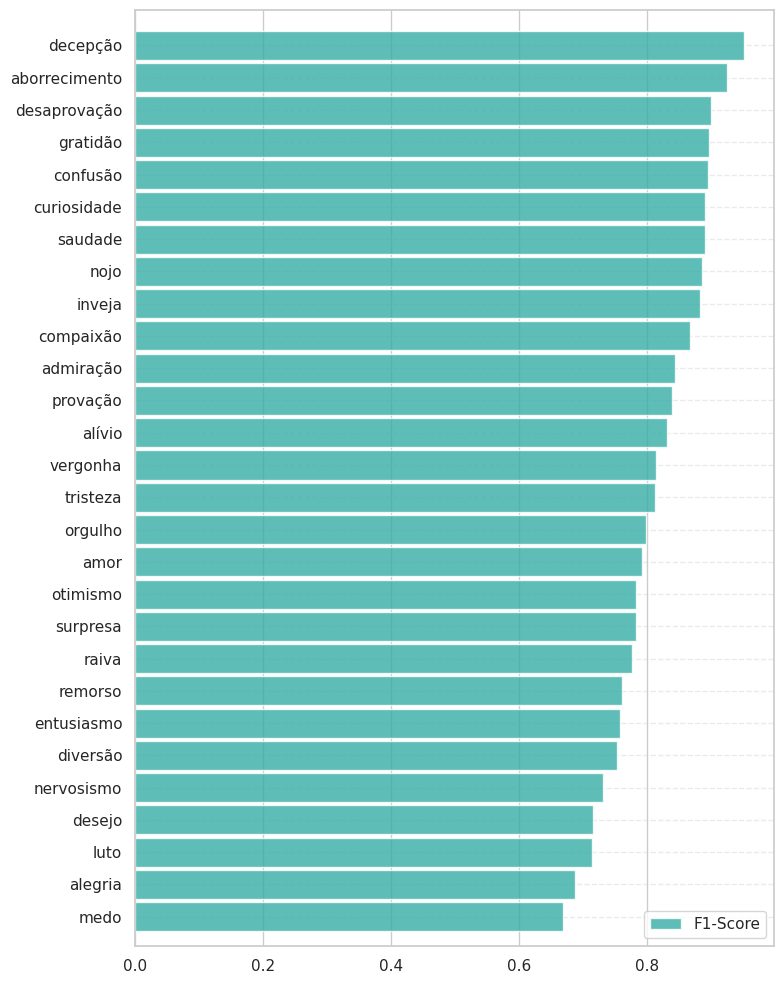

In [183]:
report_d = classification_report(labels_val_names, pred_labels_names, output_dict=True)
report_d = pd.DataFrame(report_d).transpose()

df_report_dropout = report_d.drop(['accuracy', 'macro avg', 'weighted avg'])
metric_to_compare = 'f1-score'


df_report_dropout = df_report_dropout.sort_values(by=metric_to_compare, ascending=True)


colors = sns.color_palette("husl", 2)

fig, ax = plt.subplots(figsize=(8, 10))

bar_height = 0.9
bar_positions_tf = np.arange(len(df_report_dropout))
bar_positions_cv = bar_positions_tf + bar_height

ax.barh(bar_positions_cv, df_report_dropout[metric_to_compare], height=bar_height, label='F1-Score', color=colors[1], alpha=0.8)

ax.set_yticks(bar_positions_tf + bar_height)
ax.set_yticklabels(df_report_dropout.index)

ax.legend(loc='best')
ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.set_ylim(0, len(df_report_dropout)+1)
plt.tight_layout()
plt.show()

In [175]:
df_report_dropout

,precision,recall,f1-score,support
medo,0.663717,0.672646,0.668151,223.0
alegria,0.706468,0.669811,0.687651,212.0
luto,0.639344,0.808290,0.713959,193.0
desejo,0.806061,0.642512,0.715054,207.0
nervosismo,0.718447,0.743719,0.730864,199.0
diversão,0.782383,0.725962,0.753117,208.0
entusiasmo,0.742574,0.773196,0.757576,194.0
remorso,0.772021,0.748744,0.760204,199.0
raiva,0.756219,0.795812,0.775510,191.0
surpresa,0.786127,0.777143,0.781609,175.0


#   SAVE MODEL

In [165]:
import joblib



# Caminho para a pasta
caminho_pasta = "/home/lucas/AffectiveComputing/model/"


caminho_modelo = caminho_pasta + "DCNN.keras"
joblib.dump(model, caminho_modelo)

['/home/lucas/AffectiveComputing/model/DCNN.keras']

In [166]:
model_load = joblib.load(caminho_modelo)
model_load.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 150)          4469250   
                                                                 
 conv1d_1 (Conv1D)           (None, 510, 512)          230912    
                                                                 
 dropout_2 (Dropout)         (None, 510, 512)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

# LOAD MODEL AND PREDICT VALUES IN SONG

In [201]:
import joblib



# Caminho para a pasta
caminho_pasta = "/home/lucas/AffectiveComputing/model/"


caminho_modelo = caminho_pasta + "DCNN.keras"

In [202]:
model_load = joblib.load(caminho_modelo)

In [167]:
def _preprocessing_train(dataframe, column):
    for i in range(dataframe.shape[0]):
        txt = dataframe[column][i].replace('|', ' ')
        dataframe.at[i, column] = txt
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [207]:
txt = """ Era uma vez
Mas como haveria de ser duas vezes ou três?
Quanta burrice
Era um casal
E esse casal é a gente
Eu comecei mal
Esquece o que eu disse
Veja bem, é que agora
Agora é um momento meio
Quando eu nasci eu sempre fui tão
Resumindo
A política não tá favorecendo o movimento de
Meu Deus!
Como é que eu vou dizer que acabou?
Há um tempão
Mas esse tempão nunca que vai caber na canção
Como é difícil
Pensa que o fim
Mas é que chamar de o fim me parece tão ruim
Eu vou do início
Quando a gente pensa alguma coisa, quer dizer
Algumas vezes nessa vida a gente quer um
Não, esquece
É que quando, por exemplo, um elefante
Nada a ver esse elefante
Como é que eu vou dizer que acabou?
Toda vez
Ou pelo menos quase toda vez
Tem um negócio que eu pensei essa semana
Não me lembro
Que agonia não lembrar de alguma coisa, não é mesmo?
Ha-ha-ha
Como é que eu vou dizer que acabou?
Quando a gente pensa alguma coisa, quer dizer
Algumas vezes nessa vida a gente quer um
Não, esquece
É que quando, por exemplo, um elefante
Nada a ver esse elefante
Como é que eu vou dizer que acabou?
Toda vez
Ou pelo menos quase toda vez
Tem um negócio que eu pensei essa semana
Não me lembro
Que agonia não lembrar de alguma coisa, não é mesmo?
Ha-ha-ha
Como é que eu vou dizer que acabou?"""
txt = txt.replace("\n", "|")

inputs =  pd.DataFrame({'lyrics': txt, 'song_name': ['Era uma vez']})
inputs

,lyrics,song_name
0,Era uma vez|Mas como haveria de ser duas veze...,Era uma vez


In [205]:
path = "/home/lucas/AffectiveComputing/songs_database.db"
slq3_instance = slq3(database=path)
inputs = slq3_instance.get_by_select(query='SELECT * FROM song;')
inputs.drop(["vagalume_song_url", "vagalume_song_id", "song_id"], axis=1, inplace=True)
inputs = _preprocessing_train(inputs, 'lyrics')

emotion_name = slq3_instance.get_by_select(query="SELECT name_emotion FROM emotion")
emotion_name = emotion_name.to_dict()["name_emotion"]

inputs

,song_name,lyrics
0,É Isso Ai,aí gente achou ia vida tão simples boa quase s...
1,Boate Azul/Ainda Ontem Chorei de Saudade (Com ...,doente amor procurei remédio vida noturna flor...
2,Dormi na Praça,caminhei sozinho rua falei estrelas lua deitei...
3,Desde que o Samba é Samba,tristeza senhora desde samba samba assi lágrim...
4,Sampa,alguma coisa acontece coração cruzo ipiranga a...
...,...,...
75,Aquarela,folha qualquer desenho sol amarelo cinco seis ...
76,Velha Infância,assim sonho pra mim vejo penso desde amanhecer...
77,Ciúme,quero levar vida moderninha deixar menininha s...
78,Insensatez,insensatez fez coração cuidado fez chorar dor ...


In [208]:
texts_val = inputs.lyrics

# Tokenize the texts
def tokenize_text(text):
    inputs = tokenizer(text, max_length=512, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'].numpy().flatten()

inputs_val = np.array([tokenize_text(text) for text in texts_val])
previsoes = model_load.predict(inputs_val)

previsoes

1/1 [==============================] - 0s 47ms/step


array([[0.03408123, 0.01063593, 0.02666486, 0.01980174, 0.00060573,
        0.01227373, 0.00096547, 0.02783732, 0.00735921, 0.00062397,
        0.00112212, 0.02956142, 0.02085201, 0.01375906, 0.00261076,
        0.0163722 , 0.0904303 , 0.5414747 , 0.05001884, 0.00236858,
        0.00422028, 0.01855934, 0.00634499, 0.00347023, 0.01184142,
        0.02009302, 0.00630831, 0.01974327]], dtype=float32)

In [211]:
probabilidades = model_load.predict(inputs_val)

df_resultado = pd.DataFrame(probabilidades, columns=[emotion_name[i] for i in range(len(emotion_name))])

df_resultado = pd.concat([inputs, df_resultado], axis=1)
df_resultado

1/1 [==============================] - 0s 18ms/step


,lyrics,song_name,admiração,diversão,raiva,aborrecimento,provação,confusão,curiosidade,desejo,...,nervosismo,otimismo,orgulho,alívio,remorso,tristeza,surpresa,saudade,inveja,compaixão
0,Era uma vez|Mas como haveria de ser duas veze...,Era uma vez,0.034081,0.010636,0.026665,0.019802,0.000606,0.012274,0.000965,0.027837,...,0.050019,0.002369,0.00422,0.018559,0.006345,0.00347,0.011841,0.020093,0.006308,0.019743


In [210]:
df_final = pd.DataFrame(columns=['song_name', 'emotion', 'value'])

for index, row in df_resultado.iterrows():
    song_name = row['song_name']
    for emotion in df_resultado.columns[2:]:
        value = row[emotion]
        df_final = df_final.append({'song_name': song_name, 'emotion': emotion, 'value': value}, ignore_index=True)

df_final

,song_name,emotion,value
0,Era uma vez,admiração,0.034081
1,Era uma vez,diversão,0.010636
2,Era uma vez,raiva,0.026665
3,Era uma vez,aborrecimento,0.019802
4,Era uma vez,provação,0.000606
5,Era uma vez,confusão,0.012274
6,Era uma vez,curiosidade,0.000965
7,Era uma vez,desejo,0.027837
8,Era uma vez,decepção,0.007359
9,Era uma vez,desaprovação,0.000624


In [214]:
df_final.sort_values(by=['value'], ascending=False)

,song_name,emotion,value
17,Era uma vez,amor,0.541475
16,Era uma vez,alegria,0.090430
18,Era uma vez,nervosismo,0.050019
0,Era uma vez,admiração,0.034081
11,Era uma vez,vergonha,0.029561
7,Era uma vez,desejo,0.027837
2,Era uma vez,raiva,0.026665
12,Era uma vez,entusiasmo,0.020852
25,Era uma vez,saudade,0.020093
3,Era uma vez,aborrecimento,0.019802


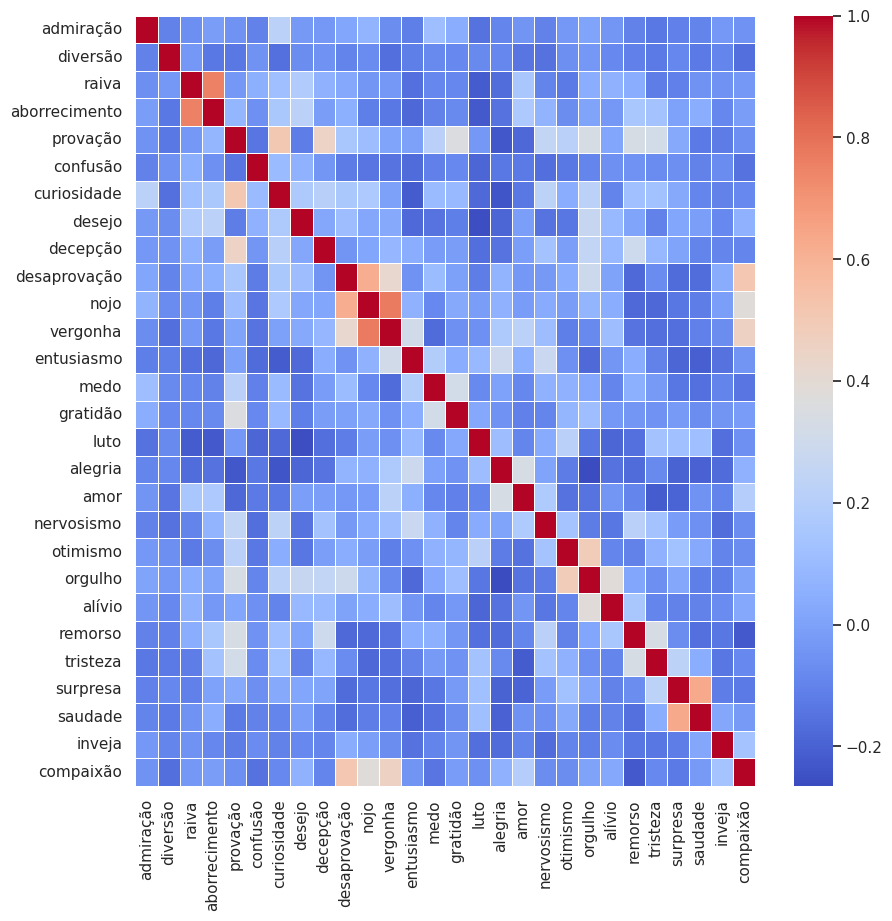

In [184]:
correlacao = df_resultado.corr()

# Criar um mapa de calor
plt.figure(figsize=(10, 10))
sns.heatmap(correlacao, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('')
plt.show()

In [200]:
describe = df_resultado.describe().transpose().drop(['count', 'max', 'min', '25%', '75%'], axis=1)
describe.sort_values(by=['std'], inplace=True, ascending=True)

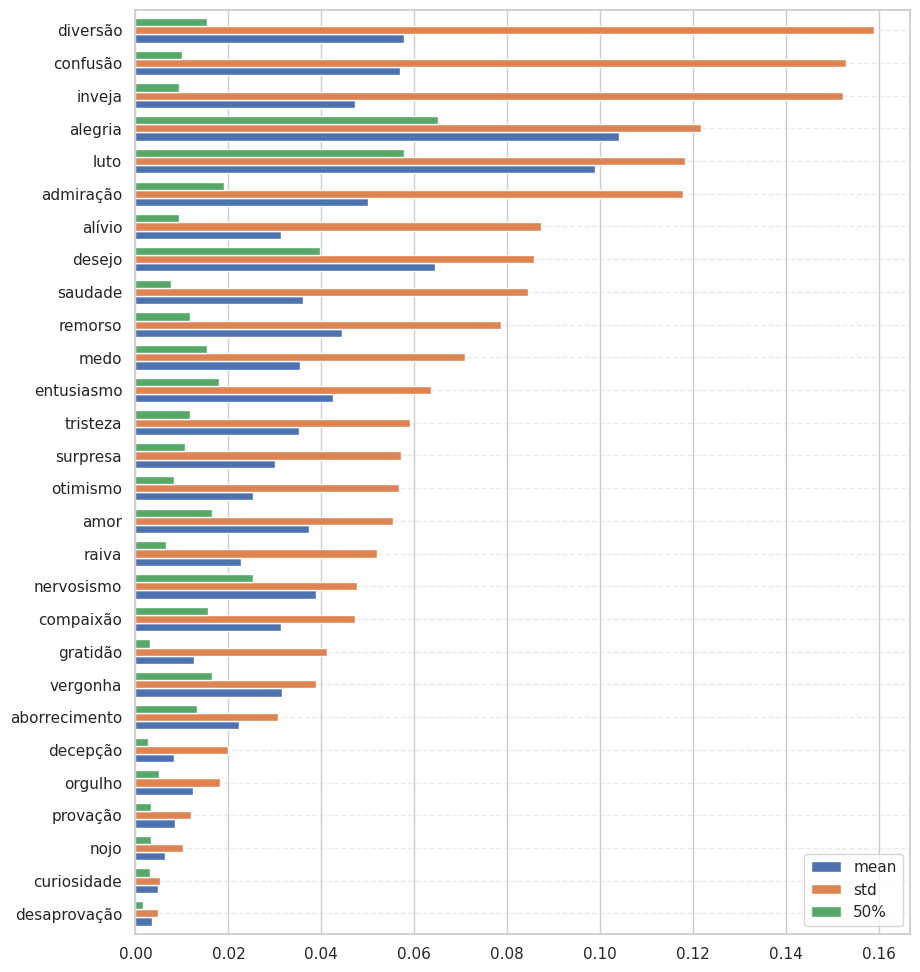

In [198]:
ax = describe.plot(
    kind='barh', figsize=(10, 12), width=0.75)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylabel('')
plt.legend()
plt.show()